In [1]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.utils import read_images_binary, read_images_text
from splat.read_utils.read_gs_ply_files import convert_to_gaussian_schema, read_ply_file

stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
# stem = "/home/da2986/intro_to_gaussian_splatting"

models_path = "/Users/derek/Downloads/models/"
ply_path = f"{models_path}/treehill/point_cloud/iteration_7000/point_cloud.ply"
vertices = read_ply_file(ply_path)
gaussians = convert_to_gaussian_schema(vertices)

colmap_path = f"{stem}/data/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras


Vertex Count: 2399849
Properties: [('float', 'x'), ('float', 'y'), ('float', 'z'), ('float', 'nx'), ('float', 'ny'), ('float', 'nz'), ('float', 'f_dc_0'), ('float', 'f_dc_1'), ('float', 'f_dc_2'), ('float', 'f_rest_0'), ('float', 'f_rest_1'), ('float', 'f_rest_2'), ('float', 'f_rest_3'), ('float', 'f_rest_4'), ('float', 'f_rest_5'), ('float', 'f_rest_6'), ('float', 'f_rest_7'), ('float', 'f_rest_8'), ('float', 'f_rest_9'), ('float', 'f_rest_10'), ('float', 'f_rest_11'), ('float', 'f_rest_12'), ('float', 'f_rest_13'), ('float', 'f_rest_14'), ('float', 'f_rest_15'), ('float', 'f_rest_16'), ('float', 'f_rest_17'), ('float', 'f_rest_18'), ('float', 'f_rest_19'), ('float', 'f_rest_20'), ('float', 'f_rest_21'), ('float', 'f_rest_22'), ('float', 'f_rest_23'), ('float', 'f_rest_24'), ('float', 'f_rest_25'), ('float', 'f_rest_26'), ('float', 'f_rest_27'), ('float', 'f_rest_28'), ('float', 'f_rest_29'), ('float', 'f_rest_30'), ('float', 'f_rest_31'), ('float', 'f_rest_32'), ('float', 'f_rest_33'

100%|██████████| 2399849/2399849 [00:09<00:00, 243866.92it/s]


[-1.1610279083251953, -1.2550954818725586, -1.4310321807861328]
tensor([0.1725, 0.1459, 0.0963])


In [3]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 100
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
wdith = 6000
height = camera_dict[image_dict[image_num].camera_id].height
height = 3744
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [4]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
scene.device = "cpu"
TILE_SIZE = 16

In [5]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    
    tile_size=TILE_SIZE
)

torch.Size([2, 1024964]) torch.Size([2, 1024964])


In [6]:
processed_gaussians.color

tensor([[0.1725, 0.1459, 0.0963],
        [0.1850, 0.1611, 0.1087],
        [0.1039, 0.0758, 0.0220],
        ...,
        [0.3215, 0.3008, 0.2785],
        [0.0000, 0.0000, 0.0000],
        [0.1153, 0.1133, 0.0749]])

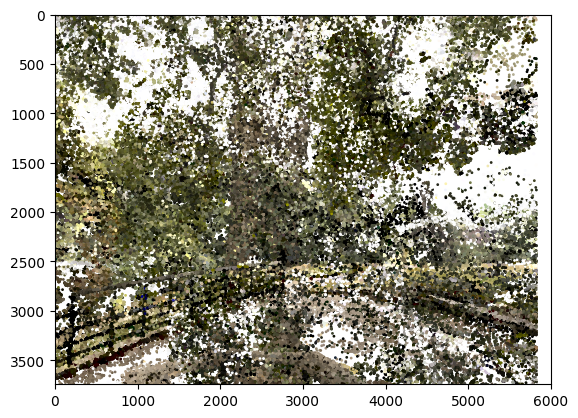

In [7]:
import matplotlib.pyplot as plt

plt.scatter(
    processed_gaussians.means_3d[:, 0].detach().cpu(),
    processed_gaussians.means_3d[:, 1].detach().cpu(),
    c=processed_gaussians.color.detach().cpu(),
    s=1,
)

plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()
plt.show()

In [7]:
from PIL import Image

image_path = "/Users/derek/Desktop/intro_to_gaussian_splatting/data/treehill/images/_DSC8973.JPG"
image = Image.open(image_path)

plt.imshow(image)
plt.show()

NameError: name 'plt' is not defined